In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000) ## 800GB?

from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns

import branca
import folium
import shared_utils

from siuba import *
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_columns', None) 

from calitp import get_engine

engine = get_engine()
connection = engine.connect()

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


# Correlation and VIF in Analytical File

In [2]:
GCS_FILE_PATH = 'gs://calitp-analytics-data/data-analyses/ahsc_grant/'

In [8]:
# start with trips per stop and ridership
analysis_tbl = gpd.read_parquet(f"{GCS_FILE_PATH}analytical_tbl.parquet")
analysis_tbl >> head (5)

,calitp_itp_id,stop_id,geometry,stop_name,n_trips_ampeak,n_trips_midday,n_trips_pmpeak,n_trips_earlyam,n_trips_latepm,n_trips_sat,n_trips_sun,n_trips_weekday,sat_ons,sun_ons,weekday_ons,sum_tracts,sum_total_pop,sum_households,sum_not_us_citizen_pop,sum_black_pop,sum_hispanic_pop,sum_youth_pop,sum_seniors_pop,sum_inc_extremelylow,sum_inc_verylow,sum_inc_low,sum_pop_determined_poverty_status,sum_poverty,sum_no_car,sum_no_cars,sum_land_area,sum_jobs,land_area_sqkm,pop_density,job_density,pct_not_us_citizen_pop,pct_black_pop,pct_hispanic_pop,pct_youth_pop,pct_seniors_pop,pct_inc_extremelylow,pct_inc_verylow,pct_inc_low,pct_poverty,pct_pop_workers_no_car,pct_hh_no_cars
0,293,670,POINT (19317.277 -398155.080),Turnpike & Ukiah,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,330.0,2,8120.0,2912.0,390.0,24.0,2348.0,2475.0,1796.0,395.0,214.0,346.0,8072.0,945.0,57.0,151.0,14540194,1774.0,14.540194,558.451971,122.006625,0.048030,0.002956,0.289163,0.304803,0.221182,0.135646,0.073489,0.118819,0.117071,0.007020,0.051854
1,293,1078,POINT (21987.751 -396450.181),Primavera & Verano,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,11850.0,4594.0,844.0,309.0,3006.0,3204.0,2602.0,970.0,525.0,929.0,10723.0,1038.0,112.0,235.0,6250912,9658.0,6.250912,1895.723376,1545.054546,0.071224,0.026076,0.253671,0.270380,0.219578,0.211145,0.114279,0.202220,0.096801,0.009451,0.051154
2,293,217,POINT (27311.975 -399717.150),De La Vina & Canon Perdido,3.0,5.0,4.0,0.0,2.0,12.0,11.0,14.0,104.0,78.0,1552.0,2,9570.0,4744.0,1421.0,246.0,3993.0,2674.0,1400.0,1355.0,834.0,905.0,9525.0,1758.0,441.0,872.0,3008305,20871.0,3.008305,3181.193396,6937.793874,0.148485,0.025705,0.417241,0.279415,0.146290,0.285624,0.175801,0.190767,0.184567,0.046082,0.183811
3,293,288,POINT (22859.915 -396883.733),La Cumbre & La Colina,11.0,20.0,14.0,0.0,1.0,11.0,11.0,46.0,13.0,8.0,570.0,2,9948.0,4340.0,773.0,34.0,1952.0,2613.0,2482.0,594.0,505.0,834.0,9751.0,716.0,130.0,379.0,5282353,10611.0,5.282353,1883.251649,2008.763897,0.077704,0.003418,0.196220,0.262666,0.249497,0.136866,0.116359,0.192166,0.073428,0.013068,0.087327
4,293,203,POINT (25145.268 -398574.222),Junipero & Alamar,8.0,10.0,8.0,0.0,1.0,12.0,11.0,27.0,93.0,38.0,911.0,3,16624.0,6945.0,1993.0,95.0,5241.0,4185.0,3693.0,920.0,993.0,1245.0,16393.0,1382.0,154.0,529.0,8935899,9756.0,8.935899,1860.361224,1091.775993,0.119887,0.005715,0.315267,0.251744,0.222149,0.132469,0.142981,0.179266,0.084304,0.009264,0.076170


In [9]:
analysis_tbl = (analysis_tbl
                >> select(-_["sum_tracts":"sum_jobs"])
               )

In [10]:
# correlation matrix
corr = analysis_tbl.corr()

/tmp/ipykernel_1416/13804554.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5]),
 [Text(0.5, 0, 'calitp_itp_id'),
  Text(1.5, 0, 'n_trips_ampeak'),
  Text(2.5, 0, 'n_trips_midday'),
  Text(3.5, 0, 'n_trips_pmpeak'),
  Text(4.5, 0, 'n_trips_earlyam'),
  Text(5.5, 0, 'n_trips_latepm'),
  Text(6.5, 0, 'n_trips_sat'),
  Text(7.5, 0, 'n_trips_sun'),
  Text(8.5, 0, 'n_trips_weekday'),
  Text(9.5, 0, 'sat_ons'),
  Text(10.5, 0, 'sun_ons'),
  Text(11.5, 0, 'weekday_ons'),
  Text(12.5, 0, 'land_area_sqkm'),
  Text(13.5, 0, 'pop_density'),
  Text(14.5, 0, 'job_density'),
  Text(15.5, 0, 'pct_not_us_citizen_pop'),
  Text(16.5, 0, 'pct_black_pop'),
  Text(17.5, 0, 'pct_hispanic_pop'),
  Text(18.5, 0, 'pct_youth_pop'),
  Text(19.5, 0, 'pct_seniors_pop'),
  Text(20.5, 0, 'pct_inc_extremelylow'),
  Text(21.5, 0, 'pct_inc_verylow'),
  Text(22.5, 0, 'pct_inc_low'),
  Text(23.5, 0, 'pct_poverty'),
  Text

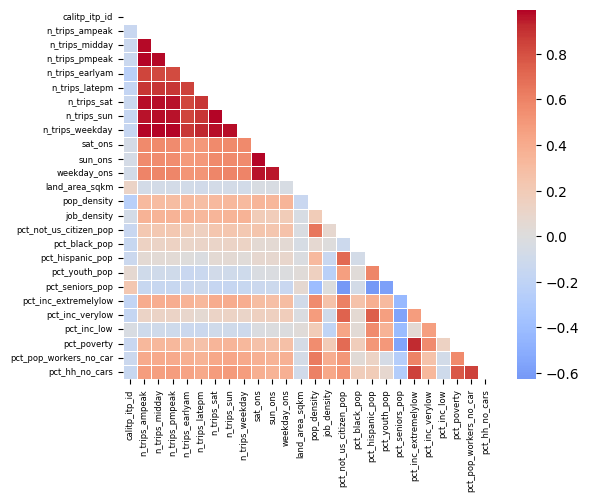

In [11]:
# Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype='bool')  
mask[np.triu_indices_from(mask)]=True

# heatmap
sns.heatmap(corr, 
            mask=mask, 
            cmap="coolwarm",
            square=True,
            linewidths=.5,
            center=0,
            xticklabels=True,
            yticklabels=True
           )

# changing the fontsize of yticks
plt.yticks(fontsize=6)
plt.xticks(fontsize=6)

In [23]:
corr

,calitp_itp_id,n_trips_ampeak,n_trips_midday,n_trips_pmpeak,n_trips_earlyam,n_trips_latepm,n_trips_sat,n_trips_sun,n_trips_weekday,sat_ons,sun_ons,weekday_ons,land_area_sqkm,pop_density,job_density,pct_not_us_citizen_pop,pct_black_pop,pct_hispanic_pop,pct_youth_pop,pct_seniors_pop,pct_inc_extremelylow,pct_inc_verylow,pct_inc_low,pct_poverty,pct_pop_workers_no_car,pct_hh_no_cars
calitp_itp_id,1.000000,-0.145178,-0.130660,-0.133481,-0.236784,-0.177314,-0.139510,-0.154540,-0.157565,-0.069118,-0.065706,-0.078689,0.114101,-0.246769,-0.070266,-0.145023,-0.147844,-0.128139,0.066941,0.233886,-0.179316,-0.167615,-0.035302,-0.142536,-0.122259,-0.146485
n_trips_ampeak,-0.145178,1.000000,0.980883,0.988399,0.838367,0.882058,0.970798,0.967854,0.989859,0.569902,0.561697,0.594027,-0.076030,0.311223,0.359292,0.221564,0.138314,0.044465,-0.095400,-0.151769,0.393365,0.123276,-0.103713,0.335334,0.408406,0.477910
n_trips_midday,-0.130660,0.980883,1.000000,0.977184,0.826748,0.886066,0.973152,0.970519,0.987211,0.566206,0.560184,0.588895,-0.073844,0.304741,0.353274,0.220643,0.117202,0.039743,-0.091442,-0.146681,0.386568,0.119728,-0.101210,0.331273,0.405775,0.472830
n_trips_pmpeak,-0.133481,0.988399,0.977184,1.000000,0.816152,0.889068,0.966729,0.964549,0.987518,0.561888,0.554242,0.586639,-0.071985,0.303669,0.357664,0.222573,0.137516,0.042458,-0.089690,-0.151012,0.391852,0.121983,-0.104268,0.334965,0.410655,0.478062
n_trips_earlyam,-0.236784,0.838367,0.826748,0.816152,1.000000,0.852519,0.830629,0.837418,0.876770,0.500565,0.493213,0.514248,-0.078371,0.317059,0.353810,0.190111,0.104795,0.008096,-0.144586,-0.133929,0.364054,0.093133,-0.122251,0.297542,0.382200,0.445424
n_trips_latepm,-0.177314,0.882058,0.886066,0.889068,0.852519,1.000000,0.882921,0.888849,0.928475,0.500395,0.499999,0.517092,-0.084180,0.290875,0.325476,0.152650,0.107803,-0.024380,-0.135144,-0.111753,0.327374,0.058044,-0.124066,0.266935,0.362110,0.414130
n_trips_sat,-0.139510,0.970798,0.973152,0.966729,0.830629,0.882921,1.000000,0.994496,0.974456,0.573197,0.565244,0.587911,-0.073680,0.318876,0.345177,0.234364,0.113676,0.052627,-0.087650,-0.153314,0.395839,0.123413,-0.099341,0.345683,0.422199,0.487075
n_trips_sun,-0.154540,0.967854,0.970519,0.964549,0.837418,0.888849,0.994496,1.000000,0.974058,0.574260,0.567791,0.590053,-0.074339,0.323619,0.352575,0.236448,0.114403,0.054209,-0.090273,-0.154526,0.398406,0.128113,-0.098339,0.347207,0.426826,0.491251
n_trips_weekday,-0.157565,0.989859,0.987211,0.987518,0.876770,0.928475,0.974456,0.974058,1.000000,0.567935,0.561471,0.590379,-0.078380,0.315404,0.363452,0.215262,0.128536,0.029953,-0.107202,-0.147288,0.391106,0.113090,-0.111584,0.330950,0.412029,0.479337
sat_ons,-0.069118,0.569902,0.566206,0.561888,0.500565,0.500395,0.573197,0.574260,0.567935,1.000000,0.985008,0.969010,-0.036899,0.343449,0.186039,0.246799,0.053098,0.071902,-0.028291,-0.126115,0.297839,0.151645,-0.019232,0.266698,0.379728,0.380365


## scatterplots of highly correlated variables

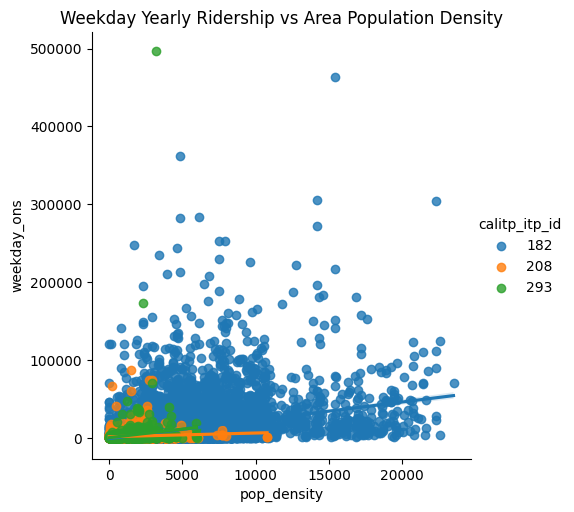

In [15]:
sns.lmplot(x="pop_density",y="weekday_ons", hue="calitp_itp_id", data=analysis_tbl).set(title="Weekday Yearly Ridership vs Area Population Density")

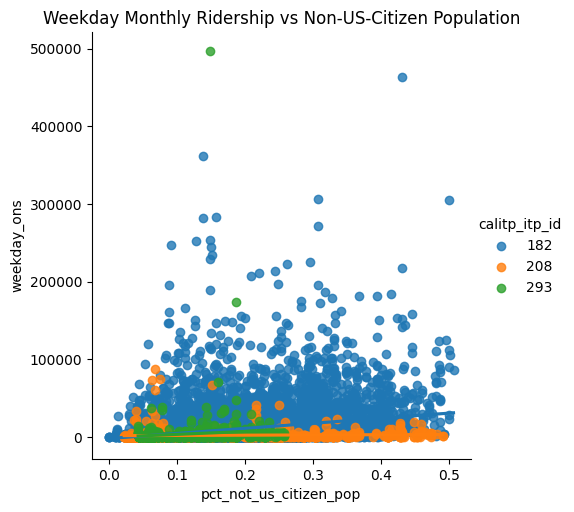

In [14]:
sns.lmplot(x="pct_not_us_citizen_pop",y="weekday_ons", hue="calitp_itp_id", data=analysis_tbl).set(title="Weekday Monthly Ridership vs Non-US-Citizen Population")

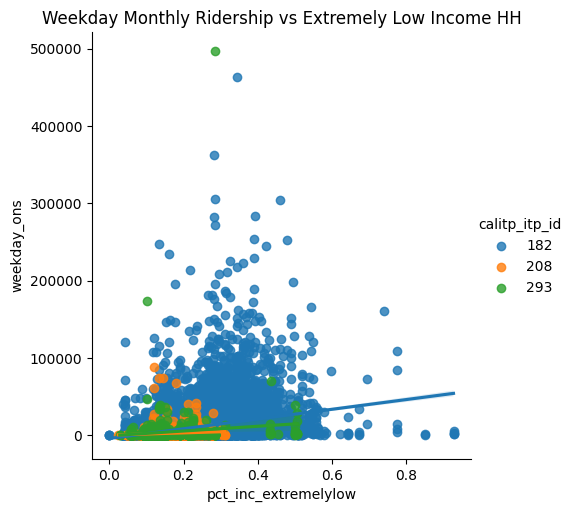

In [16]:
sns.lmplot(x="pct_inc_extremelylow",y="weekday_ons", hue="calitp_itp_id", data=analysis_tbl).set(title="Weekday Monthly Ridership vs Extremely Low Income HH")

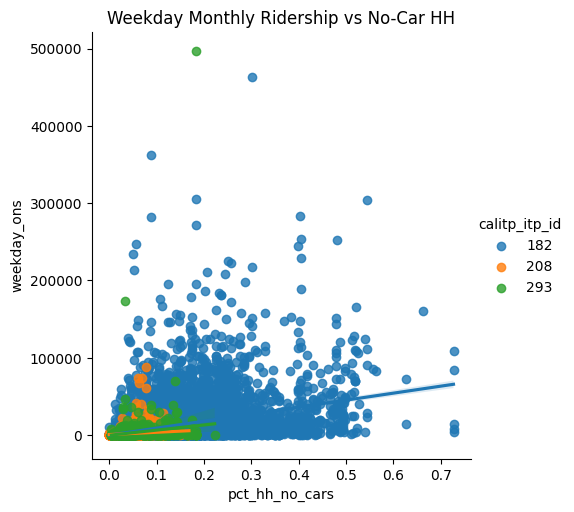

In [17]:
sns.lmplot(x="pct_hh_no_cars",y="weekday_ons", hue="calitp_itp_id", data=analysis_tbl).set(title="Weekday Monthly Ridership vs No-Car HH")

## VIF

In [18]:
# VIF function wrapper using Pandas - from Blake
def calc_vif(df:pd.DataFrame):
    '''
    Determine the variation inflaction factor for all columns in a dataframe.
    
    VIF calculation assumes a constant, so one is added as part of a wrapper function.
    https://github.com/statsmodels/statsmodels/issues/2376
    '''
    df_c = df.assign(const=1)
    vif = pd.Series([variance_inflation_factor(df_c.values, i) 
                                    for i in range(df_c.shape[1])],
                       index=df_c.columns)
    vif.drop(index=['const'], inplace=True)
    return(vif)

In [19]:
# make a regular df, drop nans
analysis_tbl_df = pd.DataFrame(analysis_tbl)
analysis_tbl_df = (analysis_tbl_df.dropna() >> select(-_["stop_name", "stop_id","geometry"]))

analysis_tbl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13723 entries, 0 to 13745
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   calitp_itp_id           13723 non-null  int64  
 1   n_trips_ampeak          13723 non-null  float64
 2   n_trips_midday          13723 non-null  float64
 3   n_trips_pmpeak          13723 non-null  float64
 4   n_trips_earlyam         13723 non-null  float64
 5   n_trips_latepm          13723 non-null  float64
 6   n_trips_sat             13723 non-null  float64
 7   n_trips_sun             13723 non-null  float64
 8   n_trips_weekday         13723 non-null  float64
 9   sat_ons                 13723 non-null  float64
 10  sun_ons                 13723 non-null  float64
 11  weekday_ons             13723 non-null  float64
 12  land_area_sqkm          13723 non-null  float64
 13  pop_density             13723 non-null  float64
 14  job_density             13723 non-null

In [20]:
calc_vif(analysis_tbl_df)

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars


calitp_itp_id               1.287358
n_trips_ampeak                   inf
n_trips_midday                   inf
n_trips_pmpeak                   inf
n_trips_earlyam                  inf
n_trips_latepm                   inf
n_trips_sat               109.308277
n_trips_sun               101.187252
n_trips_weekday                  inf
sat_ons                    52.261915
sun_ons                    34.669783
weekday_ons                17.890664
land_area_sqkm              1.047101
pop_density                 2.593361
job_density                 1.471247
pct_not_us_citizen_pop      5.546527
pct_black_pop               1.490136
pct_hispanic_pop            3.740738
pct_youth_pop               2.790934
pct_seniors_pop             2.524488
pct_inc_extremelylow       11.869088
pct_inc_verylow             3.119554
pct_inc_low                 1.876068
pct_poverty                11.554695
pct_pop_workers_no_car      6.061157
pct_hh_no_cars             12.674195
dtype: float64

## Summary Stats by operator area

Text(0, 0.5, 'Number of Stops')

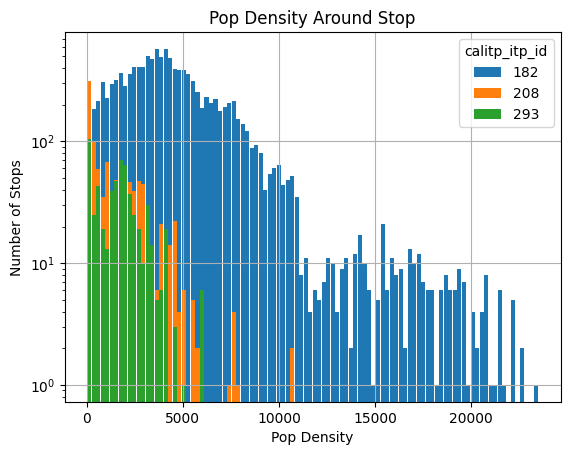

In [21]:
analysis_tbl_df.pivot(columns='calitp_itp_id', values='pop_density').plot.hist(grid=True, bins=100, rwidth=0.9, log=True,
                                          title='Pop Density Around Stop')
plt.xlabel('Pop Density')
plt.ylabel('Number of Stops')

In [22]:
analysis_tbl_df >> group_by(_.calitp_itp_id) >> summarize(pop_density_mean=_.pop_density.mean())

,calitp_itp_id,pop_density_mean
0,182,4551.773164
1,208,1395.612239
2,293,1650.126731
